In [15]:
import pandas as pd
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import pickle
import subprocess
import sys
from networkx.algorithms.community import asyn_lpa_communities as lpa

pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 10000)


def Time2Str(tsm):
    t1 = datetime.datetime.fromisoformat(tsm)
    t0 = t1-datetime.timedelta(days=0, hours=1)
    t2 = t1+datetime.timedelta(days=0, hours=1)
    str1 = t0.strftime("%Y%m%d")+'(' +str(t0.hour).rjust(2,'0')+'#'+str(t1.hour).rjust(2,'0')+')'
    str2 = t1.strftime("%Y%m%d")+'(' +str(t1.hour).rjust(2,'0')+'#'+str(t2.hour).rjust(2,'0')+')'
    return str1+';'+str2


def parse_date_convert_min(date,format='%Y-%m-%d %H:%M'):
    parse_date=parse(date)
    return parse_date.strftime(format)

def parse_date_convert_year(date,format='%Y'):
    parse_date=parse(date)
    return parse_date.strftime(format)

def parse_date_convert_day(date,format='%Y-%m-%d'):
    parse_date=parse(date)
    return parse_date.strftime(format)

def parse_date_convert_month(date,format='%Y-%m'):
    if pd.isna(date):
        return ''
    else:
        parse_date=parse(date)
        return parse_date.strftime(format)

def parse_date_convert_timestamp(date):
    parse_date=parse(date)
    return str(int(parse_date.timestamp()))

def parse_date_convert_hour(date,format='%Y-%m-%d %H'):
    parse_date=parse(date)
    return parse_date.strftime(format)


In [16]:
#load transaction data
df1=pd.read_csv('dune1.csv') #ETH , gnosis , BSC , OPT, ARBI Safe history transactions
df2=pd.read_csv('dune2.csv')
df3=pd.read_csv('dune3.csv')
df4=pd.read_csv('dune4.csv')
df5=pd.read_csv('dune5.csv')
df6=pd.read_csv('dune6.csv')
df_ords=pd.concat([df1,df2,df3,df4,df5,df6])
user_df=pd.read_csv('safe_user_allocations_reworked.csv')
user_df.rename(columns={'safe_address':'addr'},inplace=True)

df_ords['block_time_month']=df_ords['block_time'].apply(parse_date_convert_month)
df_ords['block_time_day']=df_ords['block_time'].apply(parse_date_convert_day)
df_ords['block_time_min']=df_ords['block_time'].apply(parse_date_convert_min)
df_ords['block_time_hour']=df_ords['block_time'].apply(parse_date_convert_hour)

df_ords['value_conv']=df_ords.value.astype('float64')
df_ords['token_vol']=df_ords['value_conv']/1000000000000000000

In [17]:
# get safe initial transaction 
df_safe_addr=df_ords.groupby(['to']).agg({'block_time':min}).reset_index()
df_safe_addr_detail=pd.merge(df_ords,df_safe_addr,how='inner',on=['block_time','to'])
df_safe_addr_detail.type.value_counts()

ether       53607
bnb           113
gnosis         70
arbitrum       24
op              5
Name: type, dtype: int64

In [18]:
#1 hop create safe address
df_1hop_stat=df_safe_addr_detail.groupby(['from','type']).agg({'to':'count'}).reset_index()
df_1hop_stat[df_1hop_stat['to']>1].sort_values(by='to',ascending=False).head(15)

,from,type,to
21976,0xdf21b894a490cbdf49d9de7b9d780b79f7cb0ac7,ether,17088
10278,0x66a0ff664f8509370c5d718a0f69ac1dc01f5c3d,ether,2999
19032,0xc098b2a3aa256d2140208c3de6543aaef5cd3a94,ether,588
11549,0x7421ee752e6da4f74ce5fa7f2887a4c995f13613,ether,376
7825,0x4d953115678b15ce0b0396bcf95db68003f86fb5,ether,179
22381,0xe3d32951c8ba72198207c2f36913afa5cca39476,ether,133
1233,0x0b7a434782792b539623fd72a428838ea4173b22,ether,110
16558,0xa727c953ffe3e461573736fde77d20cfdce9fca3,ether,98
3994,0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,ether,95
6189,0x3cd751e6b0078be393132286c442345e5dc49699,ether,90


In [20]:
from_addr='0xc098b2a3aa256d2140208c3de6543aaef5cd3a94'
chain_type='ether'

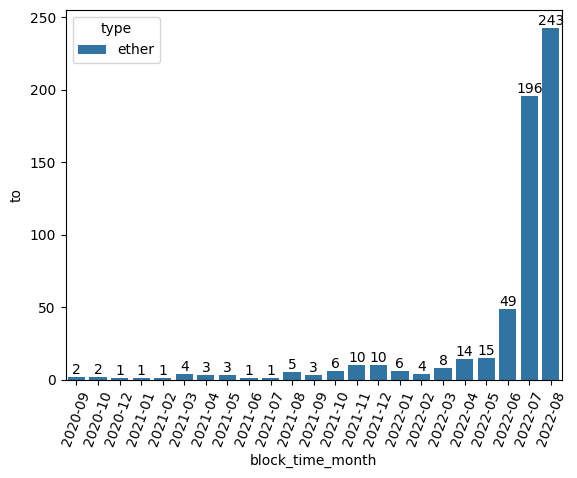

In [21]:
#safe addresses created monthly
df_1hop_monthly=df_safe_addr_detail[df_safe_addr_detail['from']==from_addr].groupby(['block_time_month','type']).agg({'to':'count'}).reset_index()

ax = sns.barplot(x="block_time_month", y="to", hue='type',data=df_1hop_monthly)
plt.xticks(rotation=70)

for i in ax.containers:
    ax.bar_label(i,)

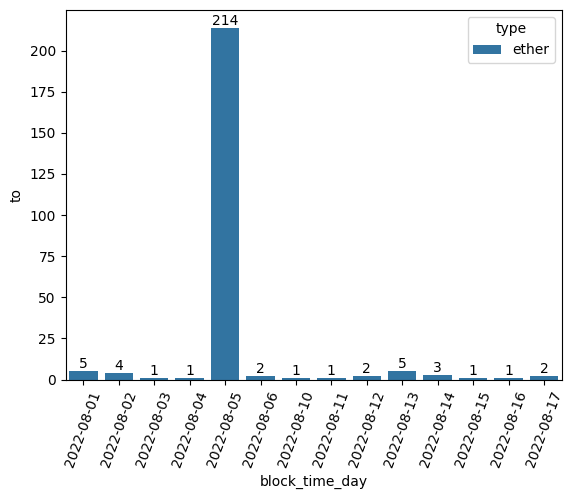

In [22]:
#safe addresses created daily

df_1hop_day=df_safe_addr_detail[(df_safe_addr_detail['from']==from_addr) &
                                    (df_safe_addr_detail['block_time_month']=='2022-08')
                                   ].groupby(['block_time_day','type']).agg({'to':'count'}).reset_index()

ax = sns.barplot(x="block_time_day", y="to", hue='type',data=df_1hop_day)
plt.xticks(rotation=70)

for i in ax.containers:
    ax.bar_label(i,)

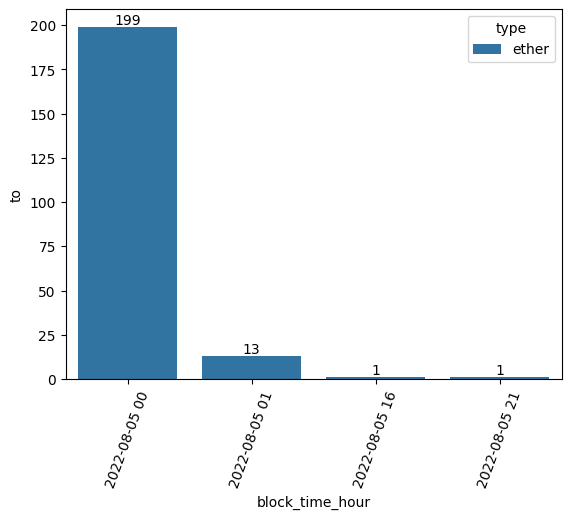

In [23]:
#safe addresses created hourly

df_1hop_hour=df_safe_addr_detail[(df_safe_addr_detail['from']==from_addr) &
                                    (df_safe_addr_detail['block_time_day']=='2022-08-05')
                                   ].groupby(['block_time_hour','type']).agg({'to':'count'}).reset_index()

ax = sns.barplot(x="block_time_hour", y="to", hue='type',data=df_1hop_hour)
plt.xticks(rotation=70)

for i in ax.containers:
    ax.bar_label(i,)

In [29]:
df_blk_lst=df_safe_addr_detail[(df_safe_addr_detail['from']==from_addr) &
                                    ((df_safe_addr_detail['block_time_hour']>='2022-08-05 00') &
                                    (df_safe_addr_detail['block_time_hour']<='2022-08-05 01'))]['addr']

df_blk_ords=pd.merge(df_ords,df_blk_lst,how='inner',on='addr')
df_blk_ords_graph=df_blk_ords.groupby(['addr','type']).agg({'token_vol':['sum','count']}).reset_index()
df_blk_ords_graph.columns = df_blk_ords_graph.columns.map('_'.join).str.strip('_')

In [34]:
df_blk_ords_block_time=df_blk_ords.sort_values(['addr','block_time'],ascending=True).groupby(['addr']).agg({'block_time':list}).reset_index()
df=pd.merge(df_blk_ords_graph,df_blk_ords_block_time,on=['addr'],how='inner')


In [40]:
df.rename(columns={"token_vol_sum": "total_volumn", "token_vol_count": "ETH","block_time":"ETH_blocktime"})
df['BSC']=0
df['Gnosis']=0
df['Optimism']=0
df['Arbitrum']=0

In [45]:
df.sort_values(by='block_time').head(10)

,addr,type,token_vol_sum,token_vol_count,block_time,BSC,Gnosis,Optimism,Arbitrum
0,0x0144347d538f485d6235cb55c8cd13b0031654ea,ether,0.00489,4,"[2022-08-05T00:27:29Z, 2022-08-05T03:52:08Z, 2...",0,0,0,0
94,0x75d6f1fb7b75e82d1334549736d6bd848ca86f1a,ether,0.00541,5,"[2022-08-05T00:27:29Z, 2022-08-05T05:01:25Z, 2...",0,0,0,0
141,0xabf8debc67c90609539830317c27cba6a207233f,ether,0.00455,4,"[2022-08-05T00:27:29Z, 2022-08-05T05:48:44Z, 2...",0,0,0,0
122,0x92de02c1447e0ce653498af9b9dd4d3cbf82a62a,ether,0.00468,4,"[2022-08-05T00:27:29Z, 2022-08-05T05:51:41Z, 2...",0,0,0,0
96,0x77739a1bae25f881245c8e6350363bf2861d0a13,ether,0.00534,4,"[2022-08-05T00:27:29Z, 2022-08-05T05:53:20Z, 2...",0,0,0,0
58,0x4adfe1805799ec381886933421fcb853db9ed3ea,ether,0.00520,4,"[2022-08-05T00:27:29Z, 2022-08-05T06:22:43Z, 2...",0,0,0,0
85,0x6935a43226faeddc102464efff26ad36536893bd,ether,0.00612,4,"[2022-08-05T00:27:29Z, 2022-08-05T06:22:43Z, 2...",0,0,0,0
99,0x7a8714a46d70f8214275b07ab7a19ebfe312b527,ether,0.00606,4,"[2022-08-05T00:28:36Z, 2022-08-05T06:22:43Z, 2...",0,0,0,0
24,0x26cf3ba8971478a88c123372475d9423260bcb0b,ether,0.00579,4,"[2022-08-05T00:28:36Z, 2022-08-05T06:22:43Z, 2...",0,0,0,0
42,0x3e33b0e2c4ac6f5e4701801edfaedf6cc8871e26,ether,0.00491,4,"[2022-08-05T00:28:36Z, 2022-08-05T06:46:37Z, 2...",0,0,0,0


In [43]:
df.to_csv('sybil_attack_report_#306.csv')

In [44]:
df[df['token_vol_count']==4].shape

(211, 9)